# Preparation

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cut_tree

from counterfactualgp.gp import GP
from counterfactualgp.mean import LinearWithBsplinesBasis
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov, linear_cov
from counterfactualgp.bsplines import BSplines
from counterfactualgp.lmm import LinearMixedModel, learn_lmm

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = 0.0, 24.0
num_basis = 5
bsplines_degree = 3
n_clusters = 3
basis = BSplines(low, high, num_basis, bsplines_degree, boundaries='space')

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_bsplines(basis, coef, n_classes):
    t = np.linspace(basis._low, basis._high, num=100)

    fig, axes = plt.subplots(nrows=1, ncols=n_classes, sharey=True, figsize=(4*n_classes, 4))
    for i,w in enumerate(coef):
        y = np.dot(basis.design(t), w)
        if isinstance(axes, np.ndarray): 
            axes[i].plot(t, y)
        else:
            axes.plot(t, y)

    plt.show()

In [6]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

# Clustering

In [7]:
def cluster_trajectories(data, xlim, basis, n_clusters, method='complete'):
    data = [(y, basis.design(x), basis.design(x)) for y,(x,_) in data]
    lmm = learn_lmm(data)
    
    beta, Sigma, v = lmm.param_copy()
    coef = np.array([lmm.posterior(*x)[0] for x in data])
    link = linkage(coef, method)
    clusters = cut_tree(link, n_clusters).ravel()
    cluster_coef = np.ndarray((n_clusters, coef.shape[1]))
    for k in range(n_clusters):
        w = coef[clusters == k].mean(axis=0)
        cluster_coef[k] = w
    
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(4*n_clusters,4), sharex=True, sharey=True)
    t = np.linspace(low, high, num=100)
    for k in range(n_clusters):
        yhat = np.dot(basis.design(t), beta) + np.dot(basis.design(t), cluster_coef[k])
        axes[k].plot(t, yhat)
    plt.show()

    return cluster_coef

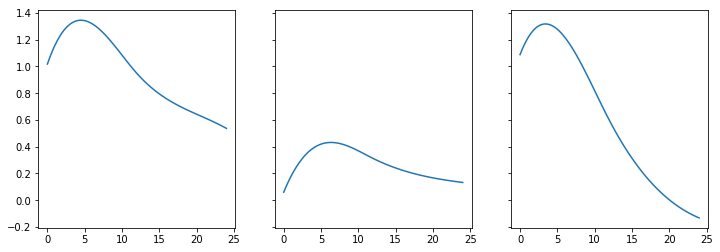

In [8]:
clustered_basis = cluster_trajectories(data['training2'], (low, high), basis, 3)

# Single GP

## Baseline GP without treatment

In [9]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, linear_cov(basis), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 4244.424429628636
obj= 4049.8702915247372
obj= 3989.615823648743
obj= 3982.103221755088
obj= 3969.4432037151414
obj= 3945.1692273239337
obj= 3901.055432407186
obj= 3832.113171604715
obj= 3807.392795909122
obj= 3805.6613910142746
obj= 3805.604982787543
obj= 3805.560307172714
obj= 3805.558468731885
obj= 3805.557980367357
obj= 3805.5579780768862
obj= 3805.557978011789
obj= 3805.557978010912
obj= 3805.5579780108574
{'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-3.18679617,  1.79139855,  0.43401578,  0.19981863, -0.10248488]), 'ln_cov_y': array([-1.44368082]), 'ln_cov_w': array([-0.72111525])}


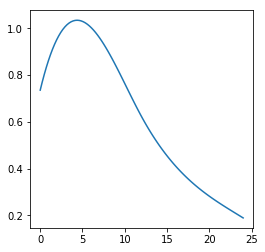

In [10]:
coef = [bgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

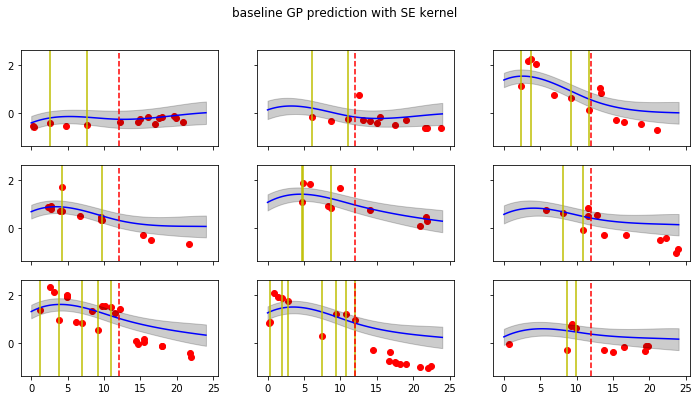

In [11]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

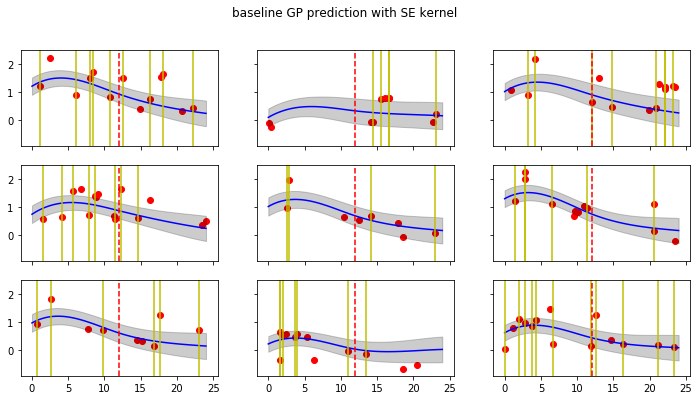

In [12]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [13]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, Treatment(2.0)) )
bgp_rx = GP(m, linear_cov(basis), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 3945.028817918209
obj= 2961.7420659060895
obj= 2768.0958400581853
obj= 2752.819712089017
obj= 2725.34120375492
obj= 2478.7385075302195
obj= 2422.9079188348574
obj= 2349.563651404256
obj= 2223.866452265156
obj= 2124.34691586149
obj= 2004.0912368735064
obj= 1997.7838228082971
obj= 1991.3426703078007
obj= 1991.058670951903
obj= 1990.9787870383636
obj= 1990.9747881638534
obj= 1990.9746130708086
obj= 1990.974611623644
obj= 1990.9746115683063
obj= 1990.9746115669748
obj= 1990.9746115669618
obj= 1990.9746115669611
{'effects_window_F': array([2.]), 'treatment': array([0.49244814]), 'ln_cov_w': array([-1.02374822]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-0.45595025,  1.09456329,  0.23616264, -0.12903853, -0.29503986]), 'ln_cov_y': array([-2.3425385])}


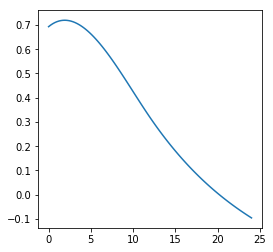

In [14]:
coef = [bgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

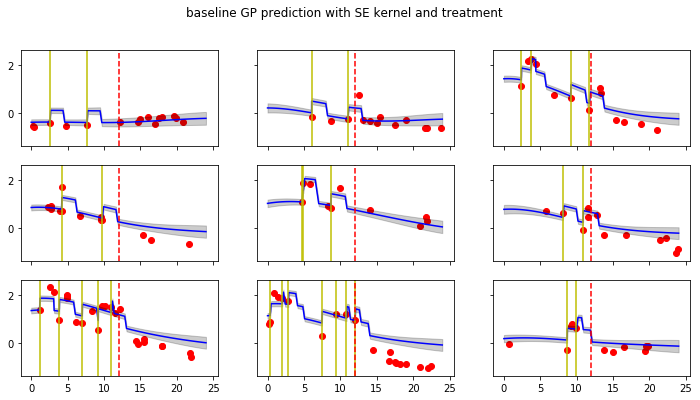

In [15]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

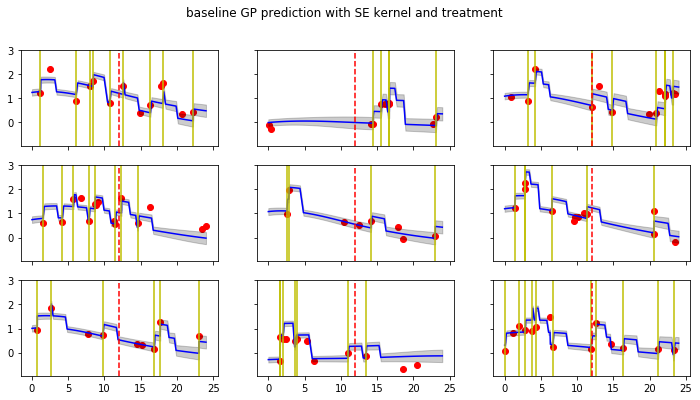

In [16]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [17]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
cgp = GP(m, linear_cov(basis), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [6833.07231594]
obj= [5725.13538453]
obj= [5591.96194997]
obj= [5462.54757706]
obj= [5454.55180121]
obj= [5387.6636838]
obj= [5358.7027986]
obj= [5308.35069316]
obj= [5252.46505239]
obj= [5231.15254536]
obj= [5229.19367089]
obj= [5229.08824639]
obj= [5229.08445801]
obj= [5229.08427462]
obj= [5229.08426823]
obj= [5229.08426765]
obj= [5229.08426764]
obj= [5229.08426764]
{'effects_window_F': array([2.]), 'treatment': array([0.53682077]), 'ln_cov_w': array([-0.97725868]), 'action': array([0.]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-1.15922909,  1.23690669,  0.17781181, -0.09706636, -0.41989632]), 'ln_cov_y': array([-2.39418621])}


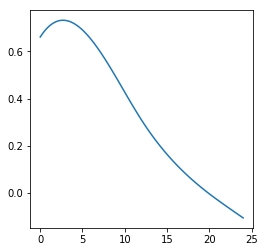

In [18]:
coef = [cgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

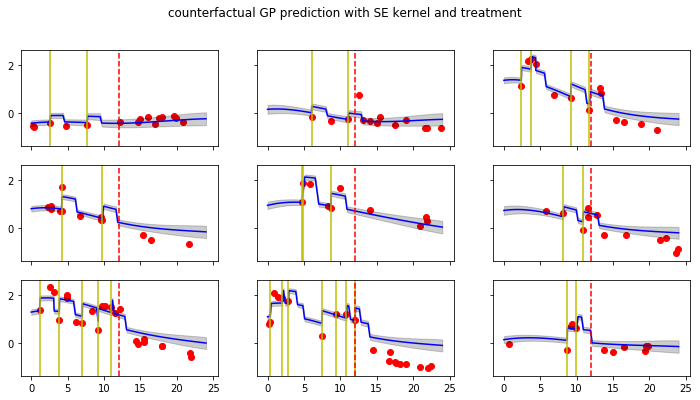

In [19]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

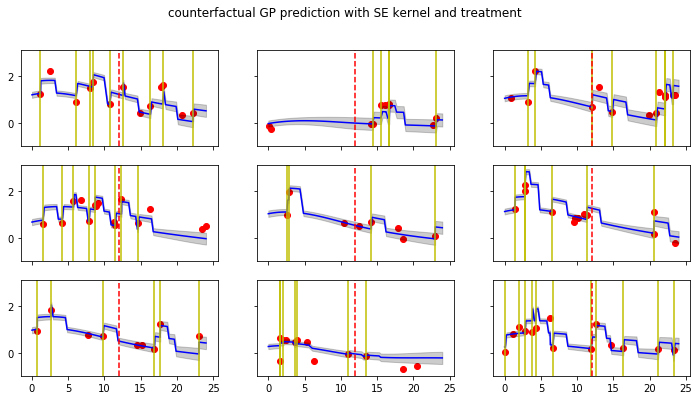

In [20]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# Mixture of GPs

## Mixture of BGPs without treatment

obj= 4254.67902612029
obj= 4150.431692623591
obj= 4086.6753628682777
obj= 4063.2933889247615
obj= 4025.855883310308
obj= 4009.51916537145
obj= 3990.159288692593
obj= 3968.650924587862
obj= 3933.9509595263257
obj= 3921.083971683653
obj= 3905.389846937478
obj= 3871.818419554151
obj= 3864.51086569244
obj= 3850.8297185347124
obj= 3829.46159771462
obj= 3826.0383480351065
obj= 3819.980775953206
obj= 3809.2005450131983
obj= 3795.5238659622682
obj= 3786.954079203114
obj= 3779.2835684316615
obj= 3770.93148237799
obj= 3760.5959437776387
obj= 3755.7211435241206
obj= 3748.1041133785284
obj= 3738.68717735315
obj= 3732.3045766174096
obj= 3726.223542417009
obj= 3724.9347180042373
obj= 3723.5382183011784
obj= 3723.281128133954
obj= 3723.094318027208
obj= 3723.0481134227134
obj= 3723.0118496433506
obj= 3723.0016204599706
obj= 3722.9987010258455
obj= 3722.9981857879357
obj= 3722.998132815882
obj= 3722.9981283959182
obj= 3722.9981280877814
obj= 3722.998128024275
obj= 3722.998128022107
obj= 3722.998128021

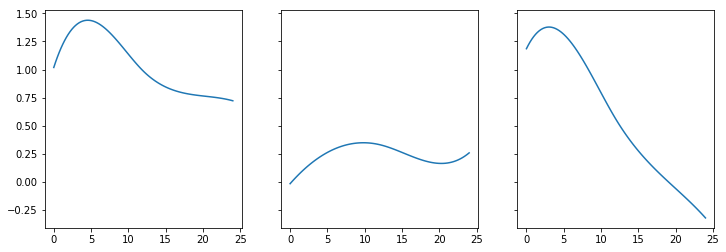

In [21]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, DummyTreatment()) )
mgp = GP(m, linear_cov(basis), tr, ac_fn=None)
mgp.fit(data['training2'], init = False)
print(mgp.params)

coef = [mgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

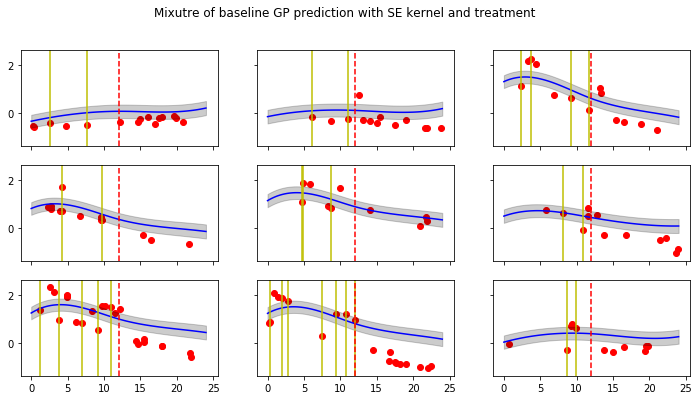

In [22]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

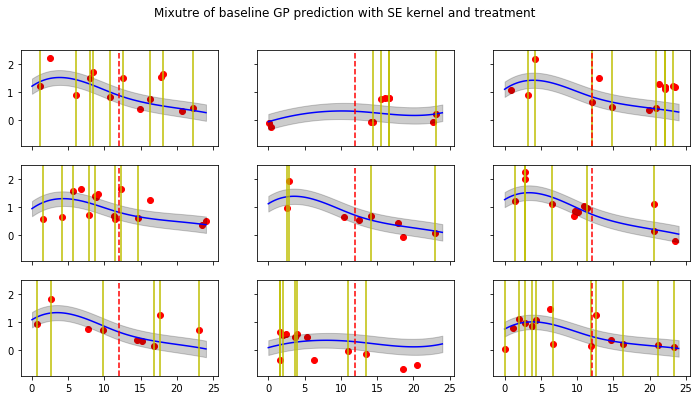

In [23]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of BGPs with treatment

obj= 3923.063557527257
obj= 2765.789557722647
obj= 2501.4065484489643
obj= 2439.740938433066
obj= 2399.303012284593
obj= 2340.7091940316723
obj= 2257.67750970697
obj= 2218.886356828482
obj= 2202.1156360872887
obj= 2182.0780236441656
obj= 2149.7715611905746
obj= 2123.112751454372
obj= 2068.2254035087285
obj= 2063.419432646847
obj= 2055.008647289869
obj= 2038.8337942147152
obj= 2008.0545188502367
obj= 1954.9524118551833
obj= 1921.7869931768162
obj= 1904.9827648437472
obj= 1883.9962251752127
obj= 1849.6571892162967
obj= 1812.94683857914
obj= 1799.9460947699283
obj= 1795.5978761440947
obj= 1793.885360933819
obj= 1792.167464095701
obj= 1791.2698210982842
obj= 1791.065432249574
obj= 1791.0332349431042
obj= 1791.0214611007373
obj= 1791.0198490481018
obj= 1791.0180193492852
obj= 1791.017975724692
obj= 1791.0179674050344
obj= 1791.0179568947888
obj= 1791.0179560002675
obj= 1791.017955893167
obj= 1791.0179558643338
obj= 1791.017955863167
obj= 1791.0179558630653
obj= 1791.0179558630462
obj= 1791.

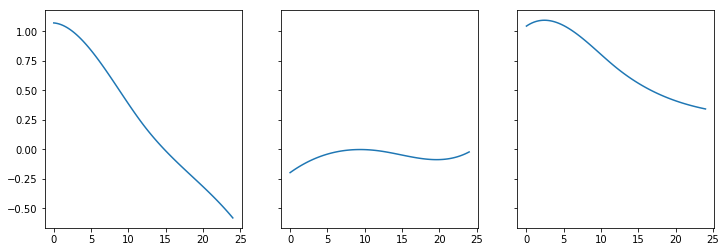

In [24]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, Treatment(2.0)) )
mgp_rx = GP(m, linear_cov(basis), tr, ac_fn=None)
mgp_rx.fit(data['training2'], init = False)
print(mgp_rx.params)

coef = [mgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

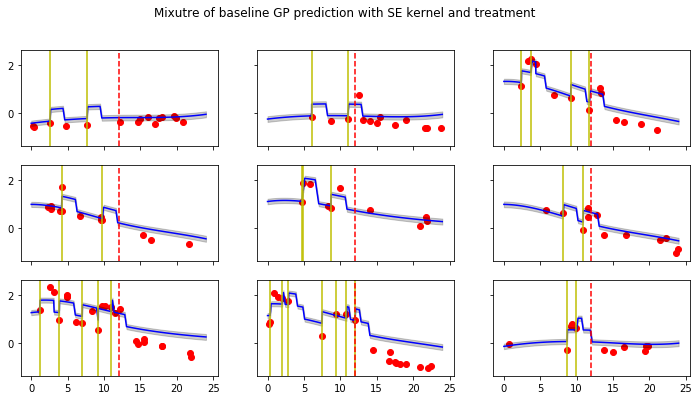

In [25]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

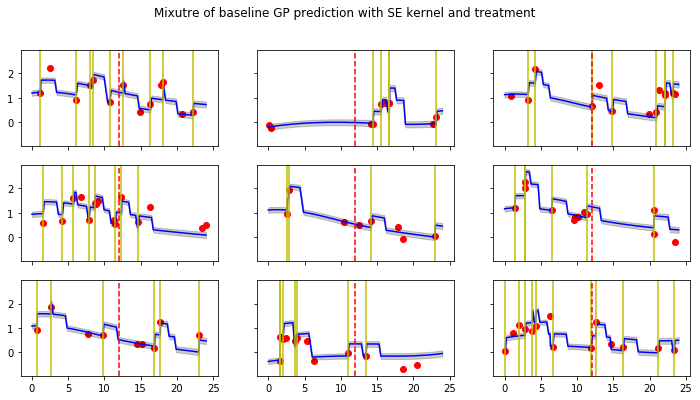

In [26]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of CGPs

obj= [6835.25030274]
obj= [5786.68396894]
obj= [5428.79915353]
obj= [5206.2324644]
obj= [5172.08746806]
obj= [5162.08325106]
obj= [5155.0626339]
obj= [5149.15050516]
obj= [5138.73197831]
obj= [5129.71408165]
obj= [5128.51466878]
obj= [5118.74485112]
obj= [5101.41243833]
obj= [5099.68472959]
obj= [5083.94366157]
obj= [5062.56826479]
obj= [5050.58009858]
obj= [5049.29803972]
obj= [5048.61115235]
obj= [5048.46679373]
obj= [5048.44517921]
obj= [5048.43588565]
obj= [5048.43424106]
obj= [5048.43405377]
obj= [5048.43403643]
obj= [5048.43402963]
obj= [5048.43402937]
obj= [5048.43402929]
obj= [5048.43402929]
obj= [5048.43402929]
obj= [5048.43402929]
obj= [5048.43402929]
obj= [5048.43402929]
obj= [5048.43402929]
{'classes_prob_logit': array([0., 0., 0.]), 'effects_window_F': array([2.]), 'treatment': array([0.52157474]), 'ln_cov_w': array([-2.63217885]), 'action': array([0.]), 'linear_with_bsplines_basis_mean_coef2': array([-0.78452211,  1.73646397, -0.04380231, -0.37004407, -2.06452998]), 'line

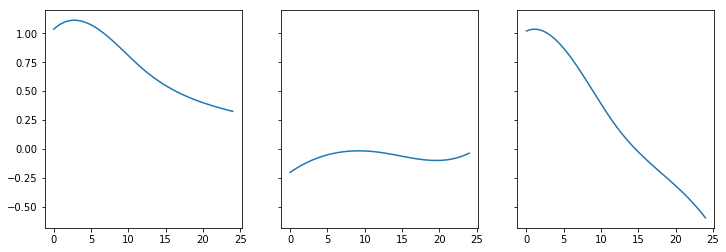

In [27]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
mcgp = GP(m, linear_cov(basis), tr, ac_fn=ac)
mcgp.fit(data['training2'], init = False)
print(mcgp.params)

coef = [mcgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

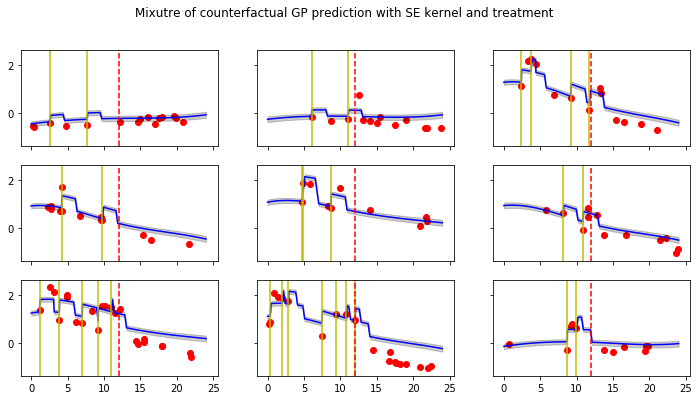

In [28]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

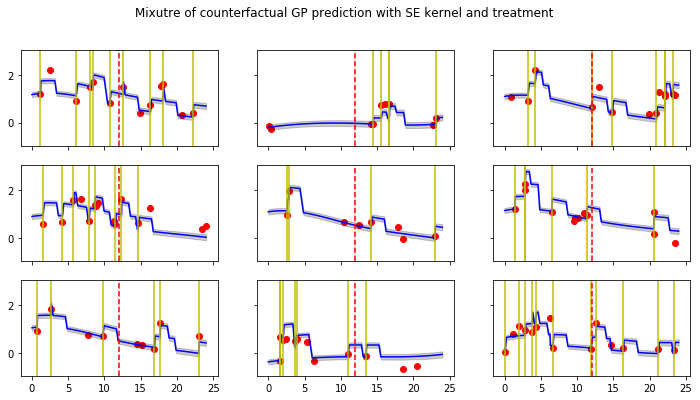

In [29]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# MSE

In [30]:
def MSE(gp, samples, truncated_time):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    s = 0.0
    for y, x in samples:
        t, rx = x
        idx = t <= truncated_time
        _y = y[idx]
        _t = t[idx]
        _rx = rx[idx]

        yhat, cov_hat = predict(gp, _y, (_t, _rx), (t, rx))
        s += np.sum((yhat[~idx] - y[~idx]) **2) / y[~idx].shape[0]
    
    return s / len(samples)

In [31]:
for s,gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['testing1'], data['truncated_time']))

bgp 0.29346955623866444
bgp_rx 0.1320274405397396
cgp 0.12588342245371748
mbgp 0.2947228140721889
mbgp_rx 0.1276361529728173
mcgp 0.11850119584166897


In [32]:
for s, gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['training2'], data['truncated_time']))

bgp 0.357811083128424
bgp_rx 0.16076364367883011
cgp 0.17447463117673126
mbgp 0.346636822319498
mbgp_rx 0.14871396151712293
mcgp 0.16424774590227356
